In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS
import gstools as gs
from geopy.distance import geodesic
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.interpolate import Rbf
from tqdm import trange
from scipy.spatial import cKDTree
pd.set_option('display.max_columns', None)

/home/arvinder/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def get_dataframe(data_path, latlon_path, start_date, end_date):
    # Initialize an empty dictionary to store dataframes and a list for site names
    data_dict = {}    
    common_index = pd.date_range(start=start_date, end=end_date)
    site_name = []

    # Iterate through each gauge directory in data_path
    for gauge in data_path:
        # Iterate through each file in the current gauge directory
        for file_name in os.listdir(gauge):
            # Append the file name to site_name list
            site_name.append(file_name.split(".xlsx")[0])
            file = os.path.join(gauge, file_name)
            
            # Read the Excel file into a dataframe
            df = pd.read_excel(file)
            
            # Check if the dataframe contains a "Date" column
            if "Date" in df.columns:
                # Convert "Date" column to datetime and set it as the index
                df["Date"] = pd.to_datetime(df["Date"])
                df.set_index("Date", inplace=True)
                
                # Read latitude and longitude data from latlon_path
                lat_lon_df = pd.read_excel(latlon_path)
                lat_lon_df.set_index("site_number", inplace=True)
                
                # Extract site number from the file name
                site_number = int(file_name.split("_")[0])
                
                # Get latitude and longitude for the current site number
                lat_lon = lat_lon_df.loc[site_number]
                latitude = float(lat_lon["Lat"])
                longitude = float(lat_lon["Long_"])
                lat_lon_tup = (latitude, longitude)
                
                # Reindex the dataframe to match the common date range
                df = df.reindex(common_index)
                df.reset_index(inplace=True)
                
                # Add the dataframe to the dictionary with the lat/lon tuple as the key
                data_dict[lat_lon_tup] = df
            else:
                # Rename columns if the dataframe does not have a "Date" column
                df.rename(columns={'DATE': 'Date', 'PRCP': 'Daily Rain (inches)', 'PRCP (in)': 'Daily Rain (inches)'}, inplace=True)
                
                # Convert "Date" column to datetime and set it as the index
                df["Date"] = pd.to_datetime(df["Date"])
                df.set_index("Date", inplace=True)
                
                # Extract latitude and longitude from the first row
                lat_lon = df.iloc[0]
                latitude = float(lat_lon["LATITUDE"])
                longitude = float(lat_lon["LONGITUDE"])
                
                # Drop unnecessary columns
                columns_to_delete = df.columns[:5]
                df.drop(columns=columns_to_delete, inplace=True)
                lat_lon_tup = (latitude, longitude)
                
                # Reindex the dataframe to match the common date range
                df = df.reindex(common_index)
                df.reset_index(inplace=True)
                
                # Add the dataframe to the dictionary with the lat/lon tuple as the key
                data_dict[lat_lon_tup] = df
    
    # Return the dictionary of dataframes and the list of site names
    return data_dict, site_name

In [3]:
prcp_path_hydromet = "/home/arvinder/interpolation/Precipitation/Hydromet"
hydromet_latlon_path = "/home/arvinder/interpolation/Precipitation/Hydromet Gage LatLong.xls"

prcp_path_NOAA = "/home/arvinder/interpolation/Precipitation/NOAA"
NOAA_latlon_path = "/home/arvinder/interpolation/Precipitation/NOAA Gage LatLong.xlsx"
LCRA_shp_pth = "/home/arvinder/interpolation/HUC4_1209/HUC4_1209.shp"

prism_shape_file_4km = "/home/arvinder/Downloads/prism_4km_mesh/prism_4km_mesh.shp"

start_date = '2000-01-01'
end_date = '2010-12-31'

# prcp_dict, site_names = get_dataframe([prcp_path_hydromet, prcp_path_NOAA], hydromet_latlon_path)
prcp_dict, site_names = get_dataframe([prcp_path_hydromet], hydromet_latlon_path, start_date, end_date)
prcp_coord = list(prcp_dict.keys())

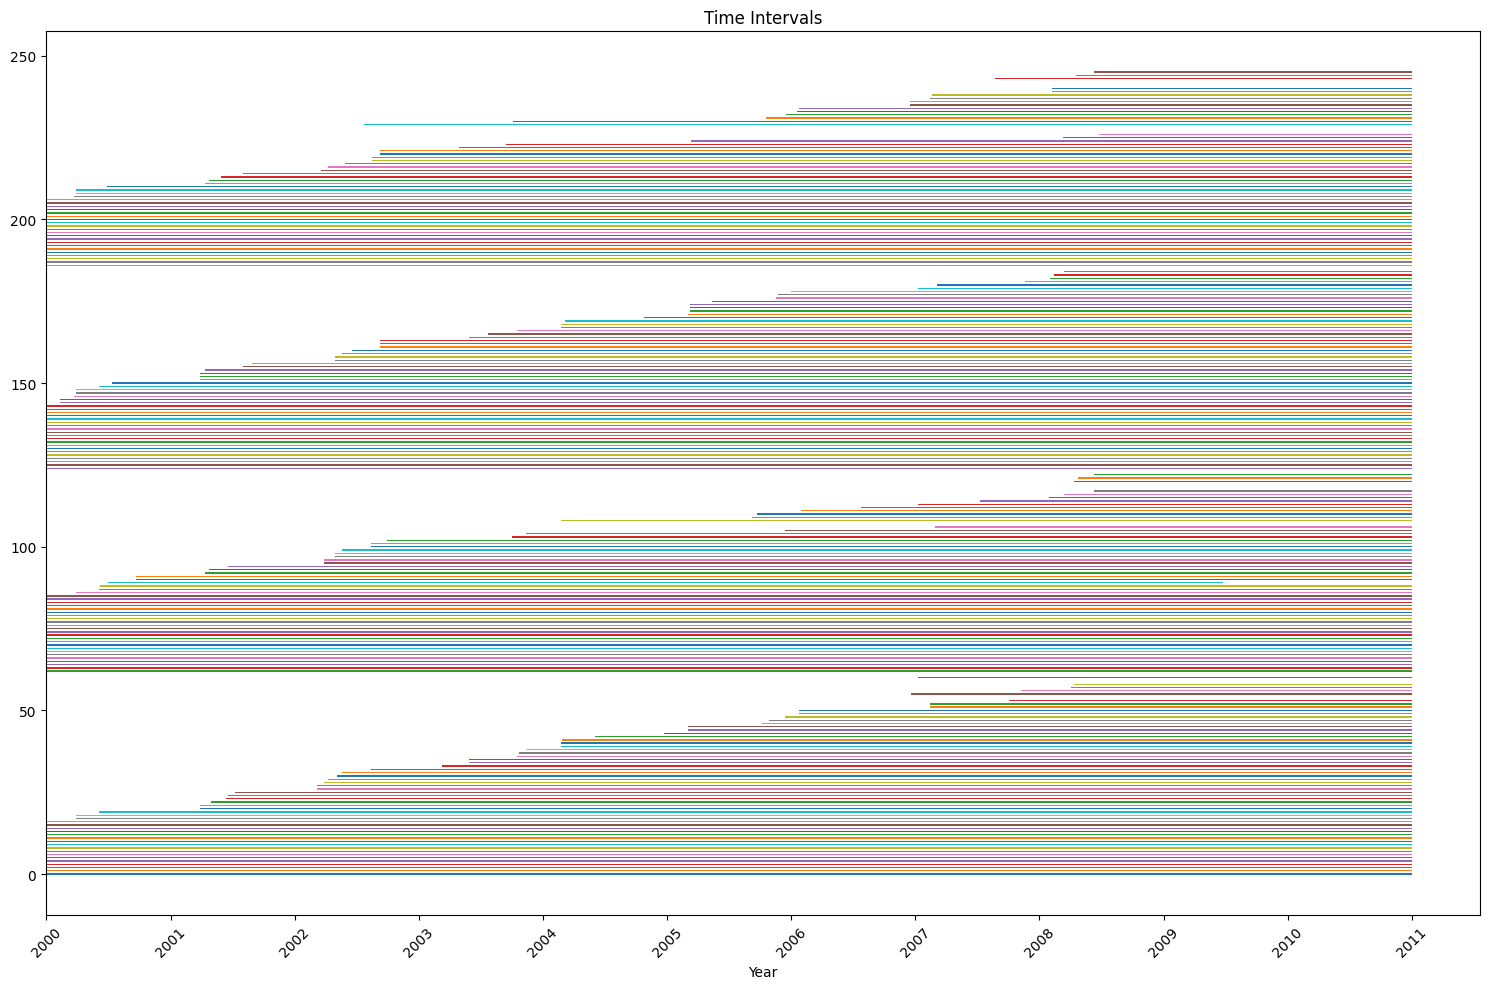

In [4]:
# Analyze data- Time distribution 

def data_time_distribution(prcp_dict):
    # Reindex dataframe with time indexing
    all_df = prcp_dict.values()
    all_df = [df.rename(columns={df.columns[0]: 'time'}) for df in all_df]
    all_df = [df.set_index('time') for df in all_df]

    # Drop nan values, Add (start, end) date to the list and then sort it on the basis of start date
    start_end = []
    for df in all_df:
        df = df.dropna()
        start_end.append((df.index.min(), df.index.max()))
    start_end = sorted(start_end, key=lambda x: x[0])

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15, 10), dpi=100)

    # Plot each interval as a horizontal bar
    for i, (start, end) in enumerate(start_end):
        ax.barh(i, (end - start).days, left=start, height=0.4, align='center')


    # Format the x-axis to show dates nicely
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Set the major ticks to every 5 years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Set labels and title
    ax.set_xlabel('Year')
    ax.set_title('Time Intervals')

    # Show the plot
    plt.tight_layout()
    plt.show()

data_time_distribution(prcp_dict)

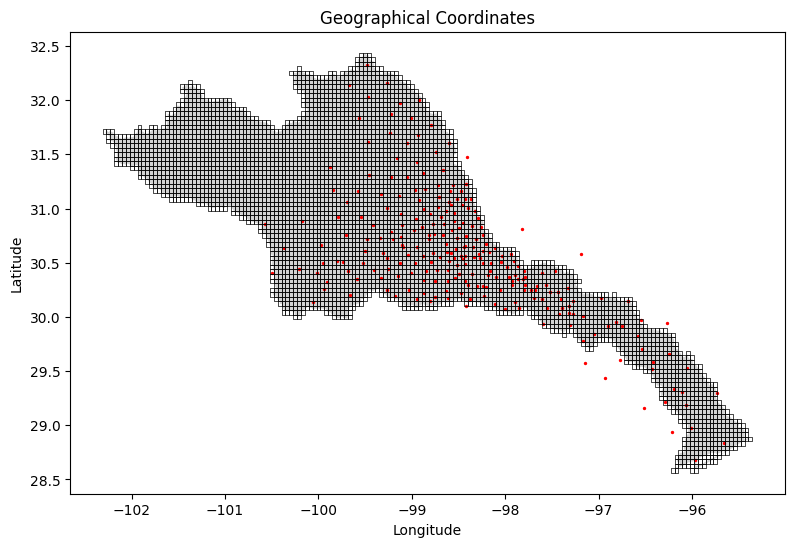

In [5]:
def get_centroid_and_plot(LCRA_shp_pth, prism_shape_file):

    #Read and Reproject the world and grid map to EPSG:3857 (meters)
    world = gpd.read_file(LCRA_shp_pth)
    world = world.to_crs(epsg=3857)

    mesh_grid = gpd.read_file(prism_shape_file)
    mesh_grid = mesh_grid.to_crs(epsg=3857)

    # Perform the intersection
    intersected_mesh = gpd.sjoin(mesh_grid, world, how='inner', predicate='intersects')

    # Reproject the world and grid map to EPSG:4326
    intersected_mesh = intersected_mesh.to_crs(epsg=4326)
    world = world.to_crs(epsg=4326)

    #Plot world, mesh and prcp data
    base = world.plot(color='lightgray', figsize=(10, 6))
    intersected_mesh.boundary.plot(ax=base, edgecolor='black', linewidth=0.5)

    prcp_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in prcp_coord], crs="EPSG:4326")
    prcp_gdf.plot(ax=base, marker='o', color='red', markersize=2)

    plt.title('Geographical Coordinates')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show the plot
    plt.show()
    
    # Calculate the centroids using an equal-area projection
    equal_area_crs = '+proj=cea'
    intersected_mesh['centroid_equal_area'] = intersected_mesh.to_crs(equal_area_crs).centroid.to_crs(intersected_mesh.crs)

    # Extract the coordinates of the centroids
    centroid_equal_area = intersected_mesh['centroid_equal_area'].apply(lambda point: (point.x, point.y)).tolist()
    # Extract x and y coordinates of centroids
    centroid_coords = np.array(centroid_equal_area)

    return centroid_coords, intersected_mesh

test_data_coords, intersected_mesh = get_centroid_and_plot(LCRA_shp_pth, prism_shape_file_4km)

In [6]:
# Convert to numpy arrays
train_coords = np.array(list(prcp_dict.keys()))
train_values = list(np.array(prcp_data['Daily Rain (inches)']) for prcp_data in prcp_dict.values())
x_coords_train = np.array(train_coords[:, 1])   #  Longitude
y_coords_train = np.array(train_coords[:, 0])   #  Latitude
# Create an array of dates between start and end date
dates = np.arange(start_date, end_date, dtype='datetime64[D]')

In [7]:
def init_kriging(dates, x_coords_train, y_coords_train, trn_values, test_data_coords, variogram_type='Exponential',
                  variance= 1, len_scale=0.9, kriging_type="Krige"):
    i = 0
    interpolated_vals = []
    interpolated_var = []

    variogram_models = {
        'Exponential': gs.Exponential,
        'Gaussian': gs.Gaussian,
        'Spherical': gs.Spherical
    }

    kriging_models = {
        'Krige': gs.krige.Krige,
        'Simple': gs.krige.Simple,
        'Ordinary': gs.krige.Ordinary,
        'Universal': gs.krige.Universal
    }

    for i in trange(len(dates), desc="Number of days"):   #len(dates)

        values = np.array([array[i] for array in trn_values])
        # Clean NaN and inf values
        valid_indices = ~np.isnan(values)
        x_coords_valid = np.array(x_coords_train)[valid_indices]
        y_coords_valid = np.array(y_coords_train)[valid_indices]
        values_valid = values[valid_indices]

        if len(values_valid) < 2:
            # Not enough valid points to perform interpolation
            interpolated_vals.append(np.full(test_data_coords.shape[0], np.nan))
            continue

        # Define a spatiotemporal variogram model
        variogram_class = variogram_models.get(variogram_type)
        model = variogram_class(dim=2, var=variance, len_scale=len_scale)

        # Create the kriging field
        kriging_class = kriging_models.get(kriging_type)
        krig = kriging_class(model, cond_pos=[x_coords_valid, y_coords_valid], cond_val=values_valid)

        # Perform the kriging
        field, variance_all = krig((test_data_coords[:, 0], test_data_coords[:, 1]))

        # Ensure non-negative values not present
        field[field < 0] = 0
        interpolated_vals.append(field)
        interpolated_var.append(variance_all)

    return interpolated_vals

In [8]:
def init_rbf(dates, x_coords_train, y_coords_train, train_values, test_data_coords, fn_type="thin_plate"):
    i = 0
    interpolated_vals = []
    
    for i in trange(len(dates), desc="Number of days"): #len(dates)
        # Extract the values for the current date
        
        values = np.array([array[i] for array in train_values])

        # Clean NaN and inf values
        valid_indices = ~np.isnan(values)
        x_coords_valid = np.array(x_coords_train)[valid_indices]
        y_coords_valid = np.array(y_coords_train)[valid_indices]
        values_valid = values[valid_indices]
        
        if len(values_valid) < 2:
            # Not enough valid points to perform interpolation
            interpolated_vals.append(np.full(test_data_coords.shape[0], np.nan))
            continue
        
        # Perform RBF interpolation using thin plate smoothing
        rbf_interpolator = Rbf(x_coords_valid, y_coords_valid, values_valid, function=fn_type)
        
        # Compute interpolated values at the centroid coordinates
        field = rbf_interpolator(test_data_coords[:, 0], test_data_coords[:, 1])
        
        # Ensure non-negative values not present
        field[field < 0] = 0
        
        interpolated_vals.append(field)
    return interpolated_vals

In [9]:
def idw_interpolation(dates, x_coords_train, y_coords_train, train_values, test_data_coords, power=2):
    interpolated_vals = []

    for i in trange(len(dates), desc="Number of days"):
        # Extract the values for the current date
        values = np.array([array[i] for array in train_values])

        # Clean NaN and inf values
        valid_indices = ~np.isnan(values)
        x_coords_valid = np.array(x_coords_train)[valid_indices]
        y_coords_valid = np.array(y_coords_train)[valid_indices]
        values_valid = values[valid_indices]

        if len(values_valid) < 2:
            # Not enough valid points to perform interpolation
            interpolated_vals.append(np.full(test_data_coords.shape[0], np.nan))
            continue

        # Construct the k-d tree for quick nearest-neighbor lookup
        tree = cKDTree(np.c_[x_coords_valid, y_coords_valid])

        # Perform IDW interpolation
        field = []
        for point in test_data_coords:
            distances, indices = tree.query(point, k=len(x_coords_valid), p=2)  # p=2 corresponds to Euclidean distance
            weights = 1 / (distances ** power)
            weights /= weights.sum()  # Normalize weights
            interpolated_value = np.sum(weights * values_valid[indices])
            field.append(interpolated_value)

        field = np.array(field)
        
        # Ensure non-negative values are handled (if necessary)
        field[field < 0] = 0
        
        interpolated_vals.append(field)
    
    return interpolated_vals


In [ ]:
interpolated_vals = idw_interpolation(dates, x_coords_train, y_coords_train, train_values, test_data_coords)

In [18]:
def plot_interpolated_data(day_to_plt, intersected_mesh, interpolated_vals):
    # Plotting
    _, ax = plt.subplots(figsize=(10, 8))
    intersected_mesh.plot(ax=ax, facecolor='none', edgecolor='blue')  # Plot the original geometries for reference

    # Plot centroids with color representing precipitation values
    ax.scatter(test_data_coords[:, 0], test_data_coords[:, 1], c=interpolated_vals[day_to_plt], cmap='viridis', s=50, alpha=0.8, vmin=0)
    plt.title('Precipitation at Centroids')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [53]:
# Validation
def sample_points(x_coords, y_coords, values_orig, sample_size):

    #  generate random array
    random_arr = np.random.randint(len(x_coords) - 1, size=(int(len(x_coords)*sample_size)))
    
    # Empty list to store random gauges
    validation_x_coords = []
    validation_y_coords = []
    validation_values = []
    # adding long/lat and values info to the empty list
    for random_num in random_arr:
        validation_x_coords.append(x_coords[random_num])
        validation_y_coords.append(y_coords[random_num])
        validation_values.append(values_orig[random_num])
        

    # Create three new lists, excluding the elements at the specified indexes
    train_x_coords = [item for idx, item in enumerate(x_coords) if idx not in random_arr]
    train_y_coords = [item for idx, item in enumerate(y_coords) if idx not in random_arr]
    train_values = [item for idx, item in enumerate(values_orig) if idx not in random_arr]

    return validation_x_coords, validation_y_coords, validation_values, train_x_coords, train_y_coords, train_values

In [54]:
def find_closest_point(given_latlon, lat_list, lon_list):
    closest_point_id = None
    min_distance = float('inf')
    
    for loc_id, (lat, lon) in enumerate(zip(lat_list, lon_list)):
        point = (lat, lon)
        distance = geodesic(given_latlon, point).kilometers
        if distance < min_distance:
            min_distance = distance
            closest_point_id = loc_id    

    return closest_point_id    

In [55]:
#  Randomly sample 20% points for validation
sample_size = 0.2

validation_x_coords, validation_y_coords, validation_values, train_x_coords, train_y_coords, train_values_sampled = sample_points(x_coords_train, y_coords_train, train_values, sample_size)

In [23]:
# Perform Kriging and store new interpolated vals
new_interpolated_vals = idw_interpolation(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords)

Number of days: 100%|██████████| 4017/4017 [07:08<00:00,  9.36it/s]


In [24]:
# Find the closest point to the radomly sampled validation points
closest_points = []
for i in trange(len(validation_x_coords), desc="Closest points"):
    clst_pt = find_closest_point((validation_y_coords[i], validation_x_coords[i]), test_data_coords[:, 1], test_data_coords[:, 0])
    closest_points.append(clst_pt)

Closest points: 100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


In [57]:
def validation_analysis(sampled_interpolated_vals, validation_values, closest_points, r_sq_threshold):
    i = 0
    new_vals = np.vstack(sampled_interpolated_vals)
    r_sq_list = []
    mae_list = []
    for ran_val in validation_values:
        observed = ran_val[:-1]
        predicted = new_vals[:, closest_points[i]]

        # Filter out NaN values
        valid_mask =  ~np.isnan(observed) & ~np.isnan(predicted)
        observed_filtered = observed[valid_mask]
        predicted_filtered = predicted[valid_mask]
        i += 1
        if observed_filtered.size > 0 and predicted_filtered.size > 0:
            r_squared = r2_score(observed_filtered, predicted_filtered)
            mae = mean_absolute_error(observed_filtered, predicted_filtered)

            r_sq_list.append(r_squared)
            mae_list.append(mae * 25.4)    # inch to mm

    num_val_stations = len(r_sq_list)
    median_r_sqr = np.median(r_sq_list)
    mean_r_sqr = np.mean(r_sq_list)

    median_mae = np.median(mae_list)
    mean_mae = np.mean(mae_list)

    count = 0

    for r_sq in r_sq_list:
        if r_sq > r_sq_threshold:
            count += 1

    num_above_threshold = count/num_val_stations

    # print(f"Number of weather stations in validation: {num_val_stations}")
    # print(f"Median R square: {median_r_sqr}")
    # print(f"Mean R square: {mean_r_sqr}")
    # print(f"Median MAE (mm/day): {median_mae}")
    # print(f"Mean MAE (mm/day): {mean_mae}")
    # print(f"No. of stations above {r_sq_threshold} R-squared: {num_above_threshold}")
    return r_sq_list, mae_list

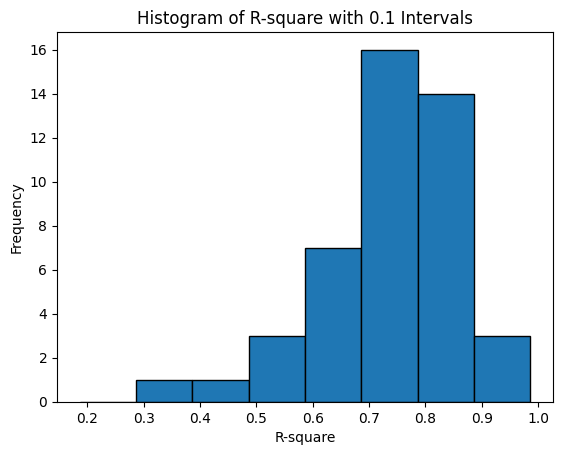

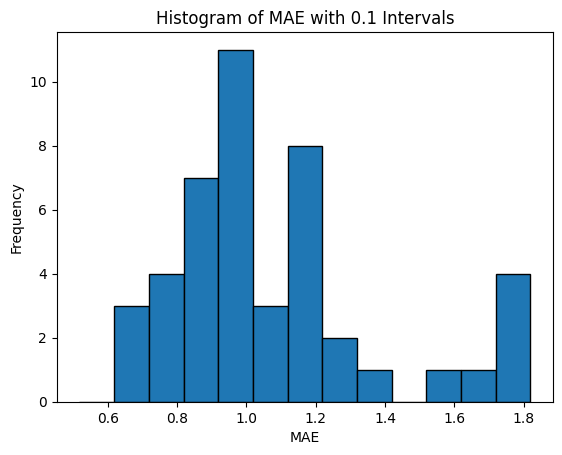

In [41]:
def plot_histogram(analyzed_data_list, type_of_data):
    interval = 0.1
    bin_edges = np.arange(min(analyzed_data_list) - interval, max(analyzed_data_list) + interval, interval)

    # Create histogram
    plt.hist(analyzed_data_list, bins=bin_edges, edgecolor='black')

    # Add labels and title
    plt.xlabel(type_of_data)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {type_of_data} with {interval} Intervals')

    # Show plot
    plt.show()

plot_histogram(r_sq_list, "R-square")
plot_histogram(mae_list, "MAE")

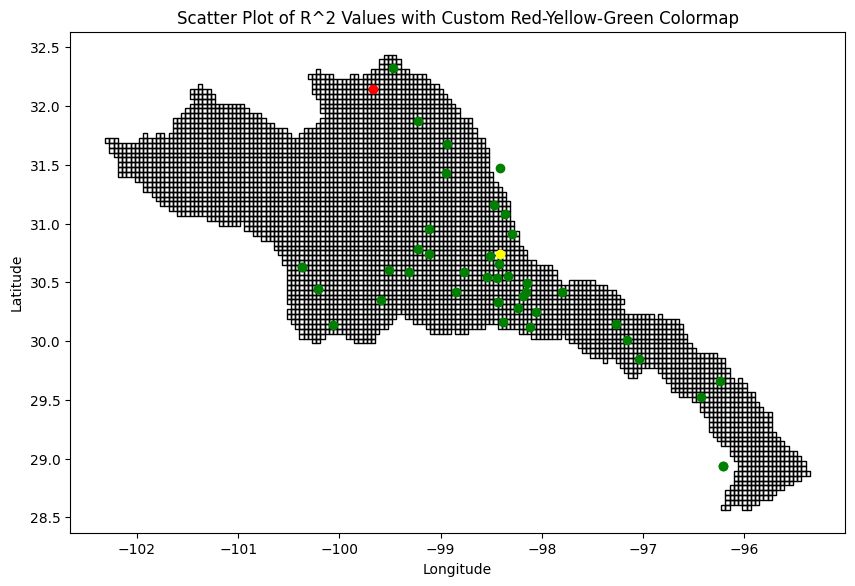

In [42]:
def plot_rsq(intersected_mesh, r_sq_list, validation_x_coords, validation_y_coords):
    # Plotting
    _, ax = plt.subplots(figsize=(10, 8))
    intersected_mesh.plot(ax=ax, facecolor='none', edgecolor='black')  # Plot the original geometries for reference

    for idx, r_sw in enumerate(r_sq_list):
        if r_sw > 0.5:
            # Create the scatter plot
            ax.scatter(validation_x_coords[idx], validation_y_coords[idx], color="green")
        if 0.3 < r_sw <= 0.5:
            # Create the scatter plot
            ax.scatter(validation_x_coords[idx], validation_y_coords[idx], color="yellow")
        if 0.3 >= r_sw :
            # Create the scatter plot
            ax.scatter(validation_x_coords[idx], validation_y_coords[idx], color="red")
        if r_sw < 0:
            ax.scatter(validation_x_coords[idx], validation_y_coords[idx], color="Black")

    plt.title('Scatter Plot of R^2 Values with Custom Red-Yellow-Green Colormap')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
plot_rsq(intersected_mesh, r_sq_list, validation_x_coords, validation_y_coords)

In [41]:
#  Density vs different interpolation techniques
def get_distance(coordinates):
    distances = []
    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            dist = geodesic(coordinates[i], coordinates[j]).km
            distances.append(dist)

    average_distance = np.mean(distances)
    return average_distance


def resample_points(coords, val, target_distance):
    # Start with the first coordinate as a selected point
    selected_points = [coords[0]]
    selected_vals = [val[0]]
    # Iterate through the remaining points
    for i , point in enumerate(coords[1:]):
        # Calculate the average distance from the current point to all selected points
        avg_distance_to_selected = np.mean([
            geodesic(point, selected_point).km
            for selected_point in selected_points
        ])

        # If the average distance is greater than or equal to the target, select the point
        if avg_distance_to_selected < target_distance:
            selected_points.append(point)
            selected_vals.append(val[i + 1])

    # Return the selected points as a numpy array
    return np.array(selected_points), np.array(selected_vals)

In [51]:
# Combine x and y coordinates into pairs
coordinates = list(zip(y_coords_train, x_coords_train))

# Distance before sampling
average_distance = get_distance(coordinates)

target_distance = average_distance * 1.4

resampled_pts, vals = resample_points(coordinates, train_values, target_distance)
resampled_pts_y = resampled_pts[:, 0]
resampled_pts_x = resampled_pts[:, 1]

In [60]:
variogram_models = {
        'Exponential': gs.Exponential,
        'Gaussian': gs.Gaussian,
        'Spherical': gs.Spherical
    }

kriging_models = {
    'Krige': gs.krige.Krige,
    'Simple': gs.krige.Simple,
    'Ordinary': gs.krige.Ordinary,
    'Universal': gs.krige.Universal
}

rbf_fn_types = ['linear', 'thin_plate_spline', "cubic", 'quintic', 'multiquadric', 'inverse_multiquadric', 'inverse_quadratic', 'gaussian']

results = []

for var_name, var_model in variogram_models.items():
    for krig_name, krig_model in kriging_models.items():
        interp_vals = init_kriging(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords, variogram_type=var_name, kriging_type=krig_name)
        closest_points = []
        for i in trange(len(validation_x_coords), desc="Closest points"):
            clst_pt = find_closest_point((validation_y_coords[i], validation_x_coords[i]), test_data_coords[:, 1], test_data_coords[:, 0])
            closest_points.append(clst_pt)
        r_sq_list, mae_list = validation_analysis(interp_vals, validation_values, closest_points, 0.7) 
        # Store the results
        results.append({
            'Variogram Model': var_name,
            'Kriging Model': krig_name,
            'R square Mean': np.mean(r_sq_list),
            'MAE mean': np.mean(mae_list)
        })
        
results_df = pd.DataFrame(results)
print(results_df)

Number of days:   2%|▏         | 100/4017 [00:04<02:44, 23.81it/s]


KeyboardInterrupt: 

In [ ]:
results2 = []

for fun_type in rbf_fn_types:
    interp_vals = init_rbf(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords, fn_type=fun_type)
    r_sq_list, mae_list = validation_analysis(interp_vals, validation_values, closest_points, 0.7) 
    # Store the results
    results2.append({
        'Model': "RBF",
        'Function type': fun_type,
        'R square Mean': np.mean(r_sq_list),
        'MAE mean': np.mean(mae_list)
    })
        
results2_df = pd.DataFrame(results2)
print(results2_df)

In [ ]:
results3 = []
interp_vals = idw_interpolation(dates, train_x_coords, train_y_coords, train_values_sampled, test_data_coords)
r_sq_list, mae_list = validation_analysis(interp_vals, validation_values, closest_points, 0.7) 
    # Store the results
results3.append({
    'Model': "IDW",
    'R square Mean': np.mean(r_sq_list),
    'MAE mean': np.mean(mae_list)
})
        
results3_df = pd.DataFrame(results3)
print(results3_df)

In [ ]:
for i in range(len(interpolated_vals)):
    raster_data = {
    "latitude": test_data_coords[:, 1],
    "longitude": test_data_coords[:, 0],
    "value": interpolated_vals[98]
    }

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(raster_data, geometry=gpd.points_from_xy(raster_data['longitude'], raster_data['latitude']))

    # Define the grid resolution (4km x 4km)
    grid_size = 0.041666666667  # 4km in degrees

    # Define the bounds of the raster
    minx, miny, maxx, maxy = gdf.total_bounds
    width = int(np.ceil((maxx - minx) / grid_size))
    height = int(np.ceil((maxy - miny) / grid_size))

    # Create an empty raster
    raster = np.full((height, width), np.nan, dtype=np.float32)  # Initialize with NaNs to identify empty cells

    # Calculate the transform
    transform = from_origin(minx, maxy, grid_size, grid_size)
    crs = CRS.from_epsg(4326)  # Assuming WGS84

    # Fill the raster with values
    for _, row in gdf.iterrows():
        rowx = int((row.geometry.x - minx) / grid_size)
        rowy = int((maxy - row.geometry.y) / grid_size)
        if 0 <= rowx < width and 0 <= rowy < height:  # Ensure indices are within bounds
            if np.isnan(raster[rowy, rowx]):
                raster[rowy, rowx] = row['value']
            else:
                # Handle multiple points in the same cell; here we take the average
                raster[rowy, rowx] = (raster[rowy, rowx] + row['value']) / 2
        else:
            print("Out of bounds")
        

    # Define the output raster file
    output_file = 'output'+ str(i) + '.tif'

    # Write the raster to a file
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,  # WGS84 Latitude/Longitude
        transform=transform,
    ) as dst:
        dst.write(raster, 1)

    break